# Part 4 - Managing your gradients.

In [1]:
import matplotlib.pyplot as plt
import torch as t
import torch.nn.functional as F

In [2]:
# Open the raw dataset and display it

words = open('datasets/names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# Display the length of words, its max, and its min

print(len(words))
print(min(len(w) for w in words))
print(max(len(w) for w in words))

32033
2
15


In [4]:
# Create an array of mappings to/from integers

strset = sorted(list(set(''.join(words))))
mapstrtoint = {s:(i + 1) for i, s in enumerate(strset)}
mapstrtoint['#'] = 0

mapinttostr = {i:s for s, i in mapstrtoint.items()}

vocab_size = len(mapinttostr)

print('Vocabulary size: {}'.format(vocab_size))

Vocabulary size: 27


(-0.5, 26.5, 26.5, -0.5)

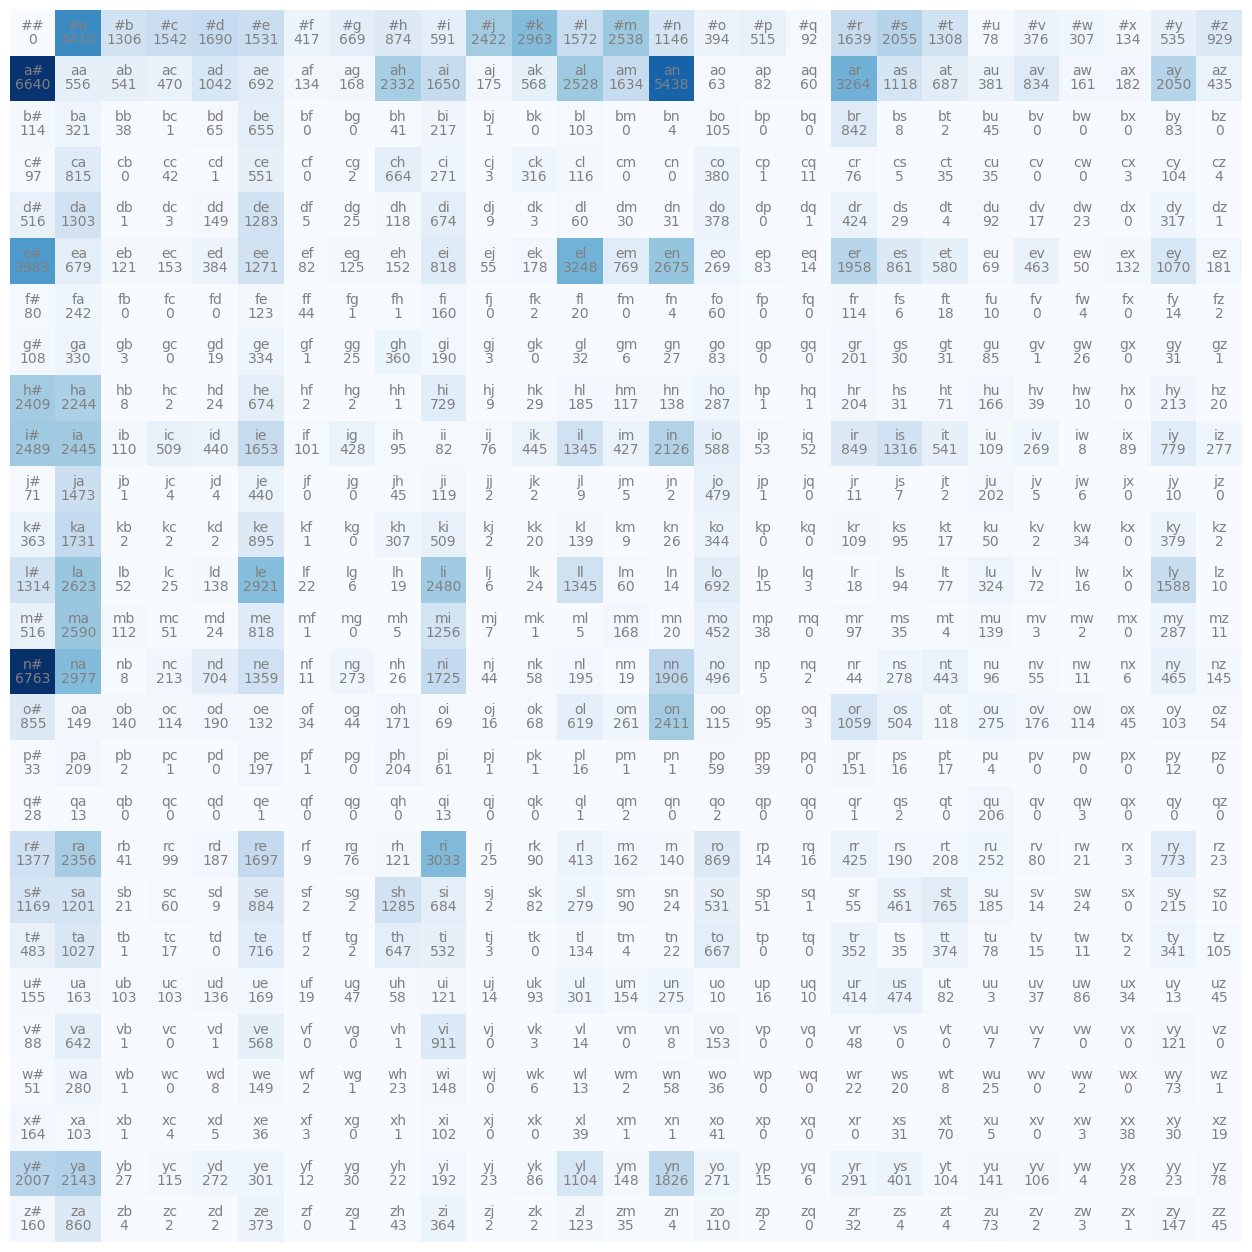

In [5]:
# Visualize the dataset

data = t.zeros((vocab_size, vocab_size), dtype=t.int32)

for w in words:
  chars = ['#'] + list(w) + ['#']
  for c1, c2 in zip(chars, chars[1:]):
    i1 = mapstrtoint[c1]
    i2 = mapstrtoint[c2]
    data[i1, i2] += 1

plt.figure(figsize=(16,16))
plt.imshow(data, cmap='Blues')
for i in range(vocab_size):
  for j in range(vocab_size):
    chstr = mapinttostr[i] + mapinttostr[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, data[i, j].item(), ha='center', va='top', color='gray')
    
plt.axis('off')

In [6]:
# Hyperparameters

input_block_size = 4
emb_dim = 10
num_layer_neurons = 200
learning_iterations = 180000
training_batch_size = 32

In [7]:
# Create a function to build a proper dataset

def build_dataset(words, block_size):
  mlp_inputs = []
  mlp_labels = []

  for w in words:
    context = [0] * block_size
    for c in w + '#':
      index = mapstrtoint[c]
      mlp_inputs.append(context)
      mlp_labels.append(index)
      context = context[1:] + [index]

  mlp_inputs = t.tensor(mlp_inputs)
  mlp_labels = t.tensor(mlp_labels)
  print(mlp_inputs.shape, mlp_labels.shape)

  return mlp_inputs, mlp_labels

In [8]:
# Build and split the dataset

import random

random.seed()
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrn, Ytrn = build_dataset(words[:n1], input_block_size)
Xdev, Ydev = build_dataset(words[n1:n2], input_block_size)
Xtes, Ytes = build_dataset(words[n2:], input_block_size)

torch.Size([182361, 4]) torch.Size([182361])
torch.Size([22849, 4]) torch.Size([22849])
torch.Size([22936, 4]) torch.Size([22936])


In [9]:
# Create the neural network model

def reset_model():
  global lookup
  global weights_hidden
  global biases_hidden
  global weights_final
  global biases_final
  global mlp_params
  
  lookup = t.randn((vocab_size, emb_dim))

  weights_hidden = t.randn((input_block_size * emb_dim, num_layer_neurons))
  biases_hidden = t.randn(num_layer_neurons)

  weights_final = t.randn((num_layer_neurons, vocab_size))
  biases_final = t.randn(vocab_size)

  mlp_params = [lookup, weights_hidden, biases_hidden, weights_final, biases_hidden]

  for p in mlp_params:
    p.requires_grad = True

  print(f'Total number of parameters: {sum(p.nelement() for p in mlp_params)}')

In [10]:
# Train the model and track the log-loss

def train(iterations):
  # Track log-loss reduction
  log_loss_hist = []
  step_hist = []

  # Initial estimate of the optimal learning rate
  optimal_learning_rate = 0.1787

  for i in range(iterations):
    # Custom learning decay
    if 2 * i > iterations:
      # Stage 2
      optimal_learning_rate = 0.0790
    elif 3 * i > iterations:
      # Stage 1
      optimal_learning_rate = 0.1393

    # Increasing batch size reduces 'noise' when training
    batch = t.randint(0, Xtrn.shape[0], (training_batch_size,))   

    # Forward pass
    emb = lookup[Xtrn[batch]]
    hidden = t.tanh(emb.view(emb.shape[0], -1) @ weights_hidden + biases_hidden)
    mlp_logits = hidden @ weights_final + biases_final

    loss = F.cross_entropy(mlp_logits, Ytrn[batch])

    # Periodically print training loss
    if i % 10000 == 0:
      print(f'{i:7d} - {loss.item()}')

    # Backward pass
    for p in mlp_params:
      p.grad = None

    loss.backward()

    for p in mlp_params:
      p.data += -optimal_learning_rate * p.grad

    # Track the log-loss
    step_hist.append(i)
    log_loss_hist.append(loss.log10().item())

  return step_hist, log_loss_hist

In [11]:
# Create a function to view the loss in each set

@t.no_grad()
def display_loss():
  losses = []
  for X, Y in [(Xtrn, Ytrn), (Xdev, Ydev), (Xtes, Ytes)]:
    emb = lookup[X] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hidden = t.tanh(embcat @ weights_hidden + biases_hidden) # (N, n_hidden)
    logits = hidden @ weights_final + biases_final # (N, vocab_size)
    loss = F.cross_entropy(logits, Y)
    losses.append(loss.item())
  
  print(f'Training loss   = {losses[0]}')
  print(f'Validation loss = {losses[1]}')
  print(f'Testing loss    = {losses[2]}')

In [12]:
# Predict

def predict(seed=None):
  if seed != None:
    gen = t.Generator().manual_seed(seed)

  generated_names = []
  for i in range(30):
    context = [0] * input_block_size

    result = ''
    while True:
      # Get logits
      emb = lookup[t.tensor([context])]
      hidden = t.tanh(emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ weights_hidden + biases_hidden)
      mlp_logits = hidden @ weights_final + biases_final

      # Exponentiate the logits and normalize them (sum to 1)
      probs = F.softmax(mlp_logits, dim=1)

      # Sample from probs to get the next character the neural network predicted
      sample_ind = t.multinomial(probs, num_samples=1, generator=gen).item()

      # End loop when the next sampled character is '#'
      if sample_ind == 0:
          break

      # Shift the context 'sliding window'
      context = context[1:] + [sample_ind]

      # Append result
      result += mapinttostr[sample_ind]

    generated_names += [result]

  print(generated_names)

In [13]:
reset_model()
steps, log_loss_hist = train(learning_iterations)

Total number of parameters: 14070
      0 - 26.121379852294922
  10000 - 3.0867955684661865
  20000 - 2.425340175628662
  30000 - 3.0621862411499023
  40000 - 2.2634780406951904
  50000 - 3.045614242553711
  60000 - 2.5756518840789795
  70000 - 2.1919145584106445
  80000 - 2.729451894760132
  90000 - 1.9100749492645264
 100000 - 2.148127317428589
 110000 - 2.4609341621398926
 120000 - 1.9268876314163208
 130000 - 2.149855136871338
 140000 - 2.244051218032837
 150000 - 1.8992794752120972
 160000 - 2.4228017330169678
 170000 - 2.2923519611358643


In [14]:
def plot_log_loss_hist(log_loss_hist, mean_window=1000):
  plt.plot(range(0, len(log_loss_hist), mean_window), t.tensor(log_loss_hist).view(-1, mean_window).mean(1))
  plt.xlabel('Steps')
  plt.ylabel('Log loss')
  plt.show()

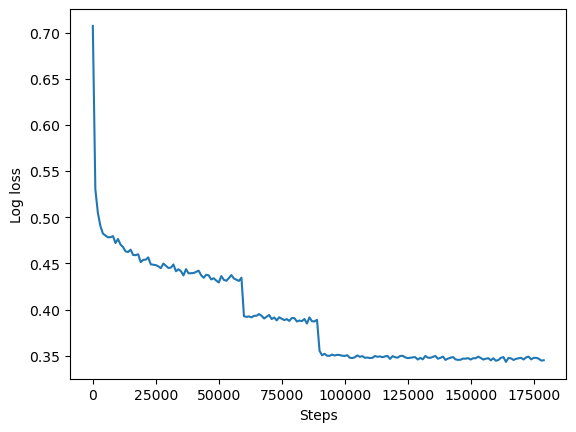

In [15]:
# Plot the rolling window loss curve

plot_log_loss_hist(log_loss_hist)

In [16]:
display_loss()

Training loss   = 2.2288432121276855
Validation loss = 2.2682278156280518
Testing loss    = 2.282275438308716


In [17]:
predict(69)

['zaiyah', 'krijanaes', 'bisra', 'theryauny', 'kirk', 'aroya', 'jaiveely', 'koirok', 'imimas', 'manee', 'siliyah', 'kailee', 'mairlailynn', 'kill', 'kilviancell', 'aydon', 'bronk', 'ryloy', 'denicleel', 'shyrose', 'inivah', 'criloe', 'yaisan', 'shi', 'arrin', 'navelaanthone', 'beoel', 'zahittelynn', 'kragleeshawn', 'maviea']


# Problem 1: Weight and Bias Initialization

At initialization, the model should set its biases as zero and its weights as a number close to zero but not zero.

This is done for several reasons,
- Control loss at initialization
- Skip an unnecessary part of the training where the model squashes down its weights, going straight to the meaningful optimization process
- Retain outputs with a normal distribution, so it doesn't expand to inf or shrink to 0.
- Control the learning rate
- Prevent the *vanishing gradient problem*

This can be easily fixed by initializing all biases before training to zeros and all weights before training to very close to zeros.

But, there exists another problem that can't be solved by only doing this,

### Oversaturation in activation functions

Here extreme weight or bias values (away from 0) can be troublesome.

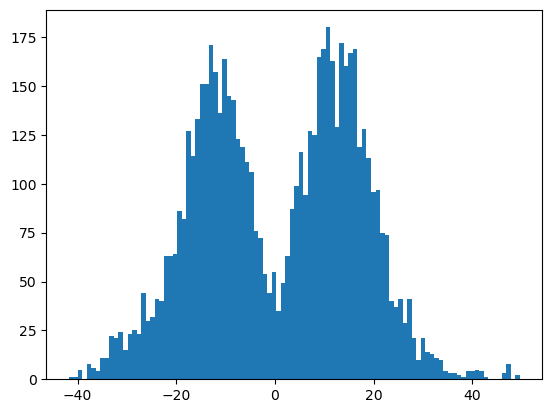

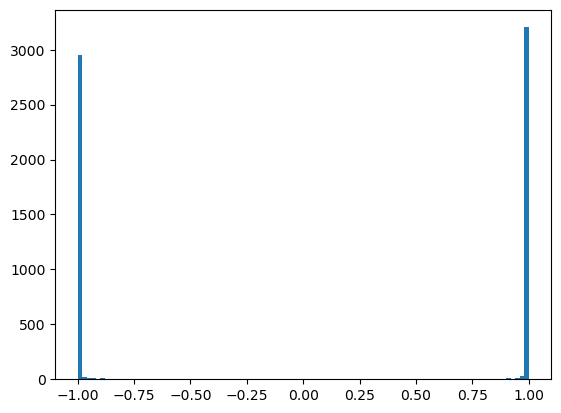

In [18]:
batch = t.randint(0, Xtrn.shape[0], (training_batch_size,))  
 
emb = lookup[Xtrn[batch]]
pre = emb.view(emb.shape[0], -1) @ weights_hidden + biases_hidden
hidden = t.tanh(pre)

# Output before activation function (tanh)
plt.hist(pre.view(-1).tolist(), 100)
plt.show()
# After activation function (tanh)
plt.hist(hidden.view(-1).tolist(), 100)
plt.show()

You can see how most of the values (output of the hidden layer) reside in the edges, either close to being -1 or 1. This is because of the extreme values of the weights or biases of that hidden layer getting squashed by the tanh activation function.

As a consequence, these extreme-valued weights or biases won't contribute to the final output because their gradients would be 0.

Picture this: If a weight of a neuron is really big, say 100, and it uses tanh as its activation function, than there would be a large range of input values where the output would be close to 1, that is about [0.04, inf). So the inputs would need to be close to 0 for the weight to have a meaningful impact to the output.

Its important to note that the gradient flowing back through tanh can only ever decrease, and so during backprop, if the output of the tanh is close to -1 or 1, the gradient flowing back would become near 0, *vanishing the gradient*.

A big problem occurs when all the outputs of a neuron's tanh activation are close to -1 or 1. In that case, the neuron's weights can only ever move by negligible amounts when it's updated in the backward pass, meaning the neuron is unable to learn. This is called a *dead neuron*.

Other nonlinear activation functions with flat regions that can encounter this problem is the sigmoid and the ReLU,
- For a dead neuron with tanh, it can only output 1 or -1, no matter the input from the dataset.
- For a dead neuron with sigmoid, it can only output 0 or 1, no matter the input from the dataset.
- For a dead neuron with ReLU, it can only output 0, no matter the input from the dataset.

Aside from improper initialization, a very high learning rate can also be a catalyst for this irreversible problem.

### Solution

The solution is to set the weight and biases of the neuron to be very close to 0 at initialization, while making sure the standard deviation of its output is as close to 1 as possible.

The goal is to make sure the output of each layer stays as normally distributed as possible. We do not want the means to shift around and the standard deviations to diffuse or concentrate at the deeper layers.

Turns out, a good initialization of all weights and biases will keep the more or less nromally distributed when training.

The precise solution to this is called the Kaiming initialization. After initializing all the weights to the **standard normal distribution**, it basically divides all the weights by the **square root of the number of inputs and multiply it by some constant**, called gain, depending on the activation function.

More details: https://pytorch.org/docs/stable/nn.init.html

However, in practice, Kaiming initialization is really hard to do because you must set a very precise gain, but de to recent innovations, this gain isn't really a big deal anymore if Kaiming is coupled with other techniques, such as batch normalization.

In [19]:
# Create the neural network model with kaiming initialization

def reset_model():
  global lookup
  global weights_hidden
  global biases_hidden
  global weights_final
  global biases_final
  global mlp_params
  
  lookup = t.randn((vocab_size, emb_dim))

  gain_tanh = 5 / 3

  std_hidden = gain_tanh / (input_block_size * emb_dim)**0.5
  weights_hidden = std_hidden * t.randn((input_block_size * emb_dim, num_layer_neurons))
  biases_hidden = 0.0 * t.randn(num_layer_neurons)

  gain_linear = 1

  std_final = gain_linear / num_layer_neurons**0.5
  weights_final =  std_final * t.randn((num_layer_neurons, vocab_size))
  biases_final = 0.0 * t.randn(vocab_size)

  mlp_params = [lookup, weights_hidden, biases_hidden, weights_final, biases_hidden]

  for p in mlp_params:
    p.requires_grad = True

  print(f'Total number of parameters: {sum(p.nelement() for p in mlp_params)}')

If the gain value is too low, the activations distribution will converge to 0 in deeper layers (The standard deviation will decrease), making the neurons inactive. 

If the gain value is too high, the activations distribution will stay at the extremes in all layers (The standard deviation will increase), which may result in the vanishing gradient problem.

In summary:
- Higher gain -> Bigger weights -> Smaller gradients -> Lower update values -> Vanishing gradient and dead neurons -> Slower training | Decrease the gain or adjust learning rate to be higher.
- Lower gain -> Smaller weights -> Bigger gradients -> Higher update values -> Instability and exploding gradients -> Slower training | Increase the gain or adjust learning rate to be lower.
- Inspect how your layers alter the gradient during backpropagation.

Note that in this notebook, the hidden layer has a tanh activation function, which corresponds to a gain = 5 / 3, while the final layer has none, which corresponds to a gain = 1.

In [20]:
reset_model()

Total number of parameters: 14070


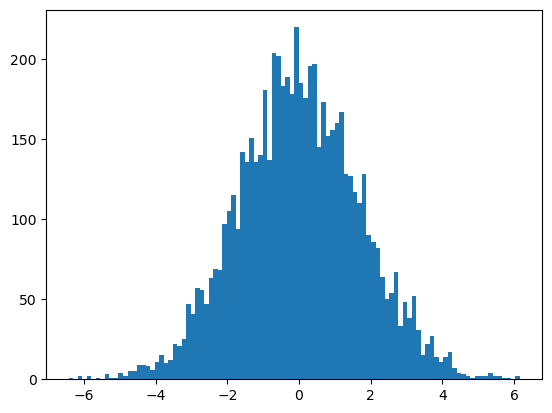

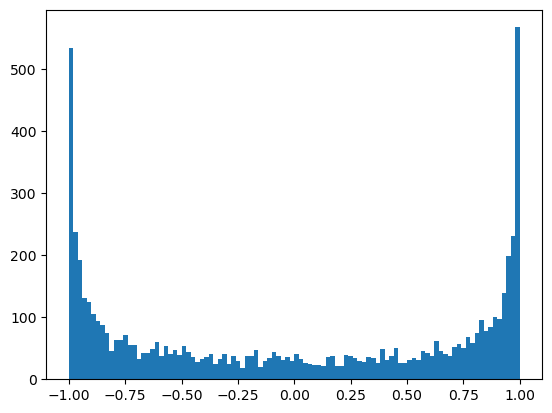

In [21]:
batch = t.randint(0, Xtrn.shape[0], (training_batch_size,))  
 
emb = lookup[Xtrn[batch]]
pre = emb.view(emb.shape[0], -1) @ weights_hidden + biases_hidden
hidden = t.tanh(pre)

plt.hist(pre.view(-1).tolist(), 100)
plt.show()
plt.hist(hidden.view(-1).tolist(), 100)
plt.show()

In [22]:
steps, log_loss_hist = train(learning_iterations)

      0 - 3.7377071380615234
  10000 - 1.956186294555664
  20000 - 2.4818456172943115
  30000 - 2.7179837226867676
  40000 - 1.9684969186782837
  50000 - 2.647935390472412
  60000 - 3.0647237300872803
  70000 - 2.1479244232177734
  80000 - 2.121400833129883
  90000 - 1.853283166885376
 100000 - 2.1525790691375732
 110000 - 1.8220912218093872
 120000 - 1.8948200941085815
 130000 - 2.539318561553955
 140000 - 2.2807748317718506
 150000 - 2.18817400932312
 160000 - 1.7709300518035889
 170000 - 2.3658173084259033


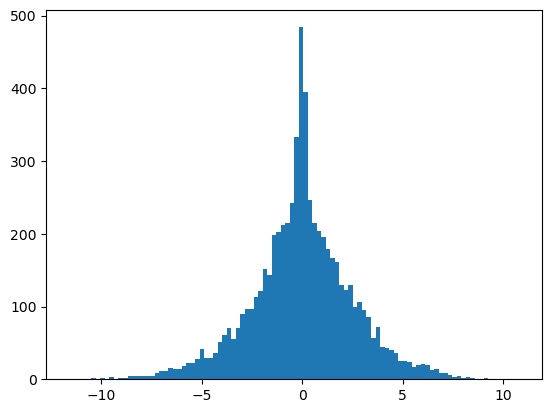

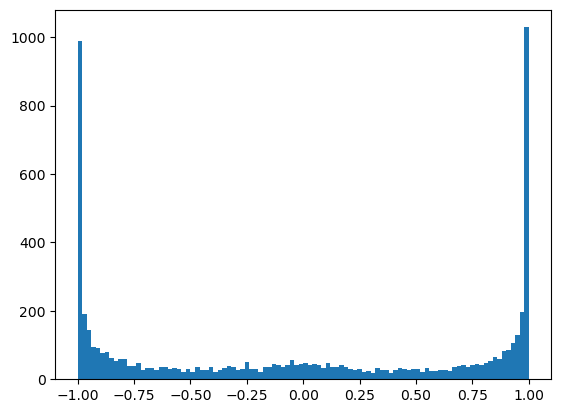

In [23]:
batch = t.randint(0, Xtrn.shape[0], (training_batch_size,))  
 
emb = lookup[Xtrn[batch]]
pre = emb.view(emb.shape[0], -1) @ weights_hidden + biases_hidden
hidden = t.tanh(pre)

plt.hist(pre.view(-1).tolist(), 100)
plt.show()
plt.hist(hidden.view(-1).tolist(), 100)
plt.show()

See how the tanh output distribution remains roughly the same?

In [24]:
display_loss()

Training loss   = 2.01714825630188
Validation loss = 2.1045472621917725
Testing loss    = 2.1237306594848633


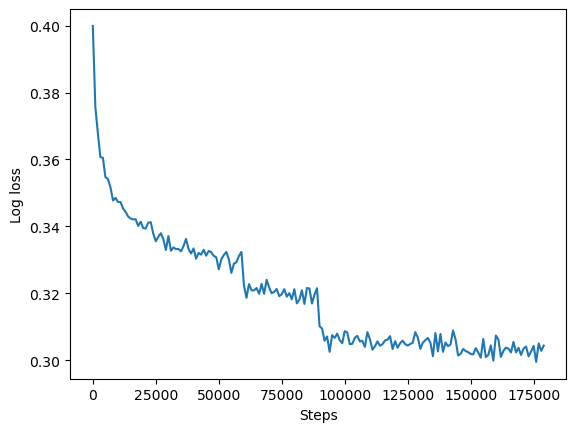

In [25]:
plot_log_loss_hist(log_loss_hist)

Looks like it even overfit!

Fortunately, modern innovation such as,
- Residual connections
- Batch normalization, layer normalization, etc.
- RMSProp and ADAM optimizer

make valibrating the initialization less important.

# Batchnorm

From everything covered so far, we know that optimally, the outputs of each hidden layer before activation function should have the standard normal distribution at initialization. Turns out, normalizing those outputs is a differentiable operation, so why not do it in the forward pass?

Batch normalization does this for each batch, while also adding scaling and shifting of those outputs to allow the neural network more freedom in shaping itself.

In [26]:
# Create the neural network model with kaiming initialization and batch normalization

def reset_model():
  global lookup
  global weights_hidden
  global biases_hidden
  global weights_final
  global biases_final
  global mlp_params

  #### Batch normalization parameters
  global batchnorm_weights
  global batchnorm_biases
  ####
  
  lookup = t.randn((vocab_size, emb_dim))

  gain_tanh = 5 / 3

  std_hidden = gain_tanh / (input_block_size * emb_dim)**0.5
  weights_hidden = std_hidden * t.randn((input_block_size * emb_dim, num_layer_neurons))
  biases_hidden = 0.0 * t.randn(num_layer_neurons)

  gain_linear = 1

  std_final = gain_linear / num_layer_neurons**0.5
  weights_final =  std_final * t.randn((num_layer_neurons, vocab_size))
  biases_final = 0.0 * t.randn(vocab_size)

  #### Add a batch normalization layer
  batchnorm_weights = t.ones(1, num_layer_neurons)
  batchnorm_biases = t.zeros(1, num_layer_neurons)
  ####

  mlp_params = [lookup, weights_hidden, biases_hidden, weights_final, biases_hidden, batchnorm_weights, batchnorm_biases]

  for p in mlp_params:
    p.requires_grad = True

  print(f'Total number of parameters: {sum(p.nelement() for p in mlp_params)}')

Please note that the biases of the hidden layer are actually useless now that there is a batchnorm layer right after it because in training it will get subtracted by the hidden layer's mean. It should actually be removed in this case, but for the purposes of this notebook I won't.

The batchnorm_biases replaces the hidden layer's biases' role.

In [27]:
# Train the model and track the log-loss, now with batch norm

def train(iterations):
  # Track log-loss reduction
  log_loss_hist = []
  step_hist = []

  # Initial estimate of the optimal learning rate
  optimal_learning_rate = 0.1787

  for i in range(iterations):
    # Custom learning decay
    if 2 * i > iterations:
      # Stage 2
      optimal_learning_rate = 0.0790
    elif 3 * i > iterations:
      # Stage 1
      optimal_learning_rate = 0.1393

    # Increasing batch size reduces 'noise' when training
    batch = t.randint(0, Xtrn.shape[0], (training_batch_size,))   

    # Forward pass
    emb = lookup[Xtrn[batch]]
    hidden = t.tanh(emb.view(emb.shape[0], -1) @ weights_hidden + biases_hidden)
    #### Batch normalization
    hidden = batchnorm_weights * (hidden - hidden.mean(0, keepdim=True)) / hidden.std(0, keepdim=True) + batchnorm_biases
    ####
    mlp_logits = hidden @ weights_final + biases_final

    loss = F.cross_entropy(mlp_logits, Ytrn[batch])

    # Periodically print training loss
    if i % 10000 == 0:
      print(f'{i:7d} - {loss.item()}')

    # Backward pass
    for p in mlp_params:
      p.grad = None

    loss.backward()

    for p in mlp_params:
      p.data += -optimal_learning_rate * p.grad

    # Track the log-loss
    step_hist.append(i)
    log_loss_hist.append(loss.log10().item())

  return step_hist, log_loss_hist

In [28]:
# Create a function to view the loss in each set, now with batch normalization

@t.no_grad()
def display_loss():
  losses = []
  for X, Y in [(Xtrn, Ytrn), (Xdev, Ydev), (Xtes, Ytes)]:
    emb = lookup[X] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hidden = t.tanh(embcat @ weights_hidden + biases_hidden) # (N, n_hidden)
    #### Batch normalization
    hidden = batchnorm_weights * (hidden - hidden.mean(0, keepdim=True)) / hidden.std(0, keepdim=True) + batchnorm_biases
    ####
    logits = hidden @ weights_final + biases_final # (N, vocab_size)
    loss = F.cross_entropy(logits, Y)
    losses.append(loss.item())
  
  print(f'Training loss   = {losses[0]}')
  print(f'Validation loss = {losses[1]}')
  print(f'Testing loss    = {losses[2]}')

In [29]:
def view_hidden_layer_distribution():
  batch = t.randint(0, Xtrn.shape[0], (training_batch_size,))  
 
  emb = lookup[Xtrn[batch]]
  pre = emb.view(emb.shape[0], -1) @ weights_hidden + biases_hidden
  hidden = t.tanh(pre)

  plt.hist(pre.view(-1).tolist(), 100)
  plt.show()
  plt.hist(hidden.view(-1).tolist(), 100)
  plt.show()

def reset_train_eval():
  reset_model()
  print("Hidden layer weights distribution at initialization:")
  view_hidden_layer_distribution()
  steps, log_loss_hist = train(learning_iterations)
  print("Hidden layer weights distribution after training:")
  view_hidden_layer_distribution()
  display_loss()
  plot_log_loss_hist(log_loss_hist)

Total number of parameters: 14470
Hidden layer weights distribution at initialization:


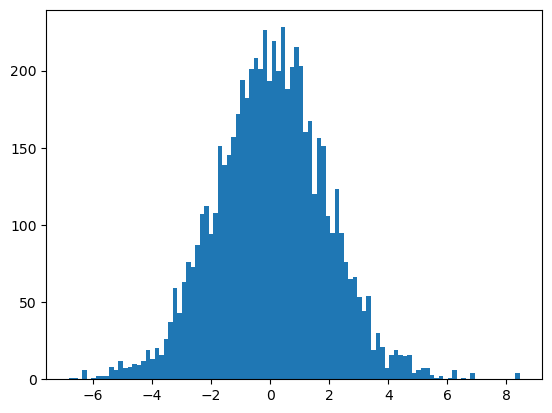

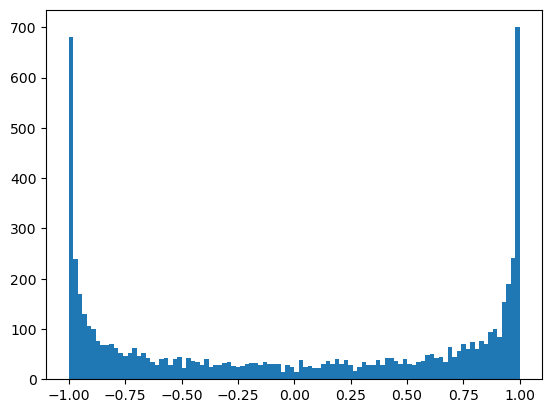

      0 - 3.601370096206665
  10000 - 2.5774738788604736
  20000 - 2.182645559310913
  30000 - 2.265772581100464
  40000 - 2.1281285285949707
  50000 - 2.339128255844116
  60000 - 2.268174409866333
  70000 - 1.9250922203063965
  80000 - 2.140573024749756
  90000 - 1.6536211967468262
 100000 - 1.7159686088562012
 110000 - 2.0161352157592773
 120000 - 2.1168758869171143
 130000 - 2.0348920822143555
 140000 - 2.498791217803955
 150000 - 1.6973320245742798
 160000 - 1.862777829170227
 170000 - 1.769211769104004
Hidden layer weights distribution after training:


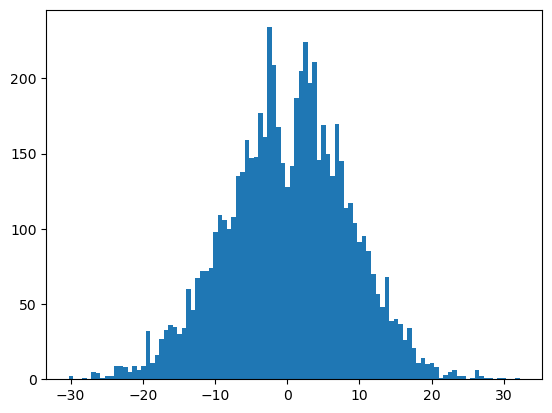

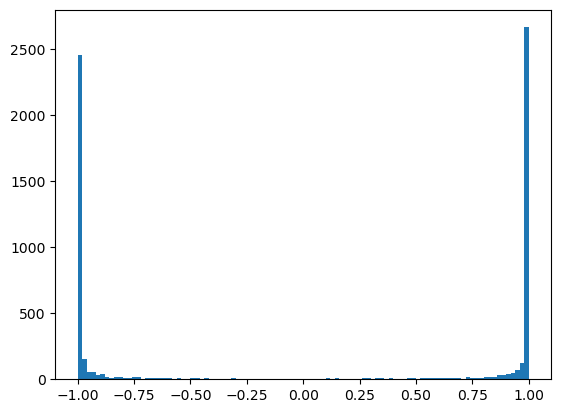

Training loss   = 1.9958664178848267
Validation loss = 2.0725700855255127
Testing loss    = 2.0939061641693115


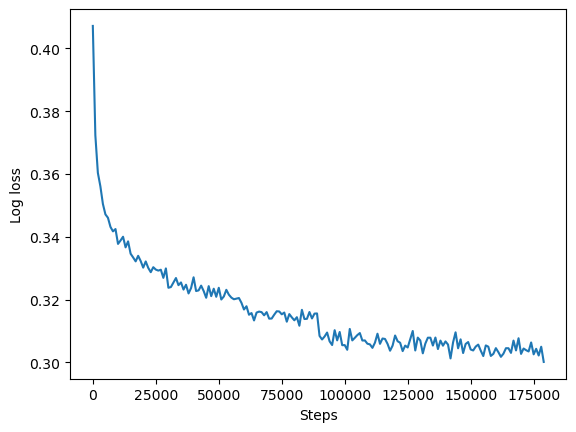

In [30]:
reset_train_eval()

As a consequence for using batch normalization, the output of a layer for a given datapoint becomes coupled on other datapoints in the same batch. This side effect is actually great for neural networks as it introduces a bit of entropy when training, effectively regularizing the neural network.

This regularization effect may or may not be desirable.

Now, because bacth normalizations depends on a batch, the model requires a whole batch to be fed in for inference. How to do inference for only a single example?

The answer is to estimate a running mean and standard deviation while training.

In [31]:
# Create the neural network model with kaiming initialization and batch normalization

def reset_model():
  global lookup
  global weights_hidden
  global biases_hidden
  global weights_final
  global biases_final
  global mlp_params

  global batchnorm_weights
  global batchnorm_biases

  ####
  global batchnorm_running_mean
  global batchnorm_running_std
  ####
  
  lookup = t.randn((vocab_size, emb_dim))

  gain_tanh = 5 / 3

  std_hidden = gain_tanh / (input_block_size * emb_dim)**0.5
  weights_hidden = std_hidden * t.randn((input_block_size * emb_dim, num_layer_neurons))
  biases_hidden = 0.0 * t.randn(num_layer_neurons)

  gain_linear = 1

  std_final = gain_linear / num_layer_neurons**0.5
  weights_final =  std_final * t.randn((num_layer_neurons, vocab_size))
  biases_final = 0.0 * t.randn(vocab_size)

  batchnorm_weights = t.ones(1, num_layer_neurons)
  batchnorm_biases = t.zeros(1, num_layer_neurons)

  ####
  batchnorm_running_mean = t.zeros(1, num_layer_neurons)
  batchnorm_running_std = t.ones(1, num_layer_neurons)
  ####

  mlp_params = [lookup, weights_hidden, biases_hidden, weights_final, biases_hidden, batchnorm_weights, batchnorm_biases]

  for p in mlp_params:
    p.requires_grad = True

  print(f'Total number of parameters: {sum(p.nelement() for p in mlp_params)}')

In [35]:
# Train the model and track the log-loss, now with batch norm

def train(iterations):
  # Track log-loss reduction
  log_loss_hist = []
  step_hist = []

  # Initial estimate of the optimal learning rate
  optimal_learning_rate = 0.1787

  for i in range(iterations):
    # Custom learning decay
    if 2 * i > iterations:
      # Stage 2
      optimal_learning_rate = 0.0790
    elif 3 * i > iterations:
      # Stage 1
      optimal_learning_rate = 0.1393

    # Increasing batch size reduces 'noise' when training
    batch = t.randint(0, Xtrn.shape[0], (training_batch_size,))   

    # Forward pass
    emb = lookup[Xtrn[batch]]
    hidden = t.tanh(emb.view(emb.shape[0], -1) @ weights_hidden + biases_hidden)
    ####
    hidden_mean = hidden.mean(0, keepdim=True)
    hidden_std = hidden.std(0, keepdim=True)
    hidden = batchnorm_weights * (hidden - hidden_mean) / hidden_std + batchnorm_biases
    ####
    mlp_logits = hidden @ weights_final + biases_final

    ####
    with t.no_grad():
      global batchnorm_running_mean
      global batchnorm_running_std
      # Here, the momentum is 0.001. You want to set this lower the smaller the batch size to allow for convergence.
      batchnorm_running_mean = batchnorm_running_mean * 0.999 + hidden_mean * 0.001
      batchnorm_running_std = batchnorm_running_std * 0.999 + hidden_std * 0.001
    ####

    loss = F.cross_entropy(mlp_logits, Ytrn[batch])

    # Periodically print training loss
    if i % 10000 == 0:
      print(f'{i:7d} - {loss.item()}')

    # Backward pass
    for p in mlp_params:
      p.grad = None

    loss.backward()

    for p in mlp_params:
      p.data += -optimal_learning_rate * p.grad

    # Track the log-loss
    step_hist.append(i)
    log_loss_hist.append(loss.log10().item())

  return step_hist, log_loss_hist

In [33]:
# Create a function to view the loss in each set, now with batch normalization

@t.no_grad()
def display_loss():
  losses = []
  for X, Y in [(Xtrn, Ytrn), (Xdev, Ydev), (Xtes, Ytes)]:
    emb = lookup[X] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hidden = t.tanh(embcat @ weights_hidden + biases_hidden) # (N, n_hidden)
    hidden = batchnorm_weights * (hidden - batchnorm_running_mean) / batchnorm_running_std + batchnorm_biases
    logits = hidden @ weights_final + biases_final # (N, vocab_size)
    loss = F.cross_entropy(logits, Y)
    losses.append(loss.item())
  
  print(f'Training loss   = {losses[0]}')
  print(f'Validation loss = {losses[1]}')
  print(f'Testing loss    = {losses[2]}')

Total number of parameters: 14470
Hidden layer weights distribution at initialization:


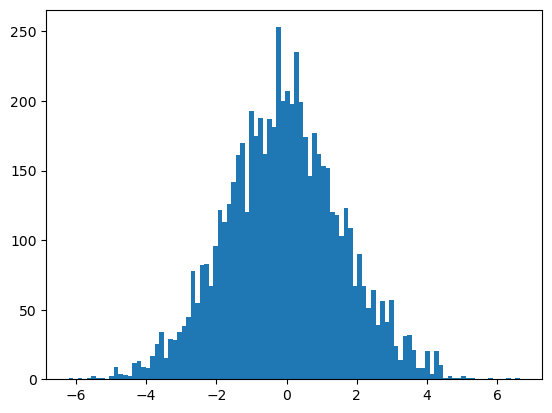

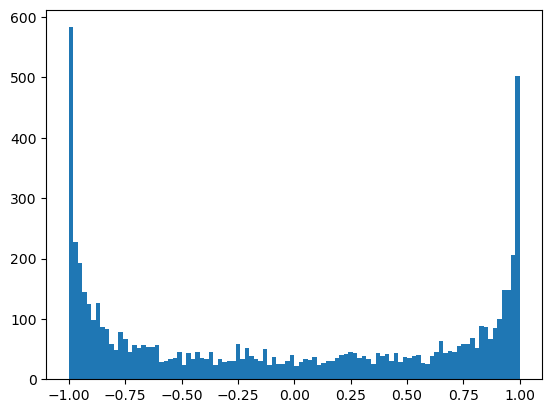

      0 - 3.987860918045044
  10000 - 2.0084362030029297
  20000 - 2.3110241889953613
  30000 - 2.2757463455200195
  40000 - 2.2673211097717285
  50000 - 1.7463843822479248
  60000 - 1.998298168182373
  70000 - 2.3450117111206055
  80000 - 1.943352222442627
  90000 - 2.104381799697876
 100000 - 2.242222785949707
 110000 - 2.0621912479400635
 120000 - 1.89231538772583
 130000 - 2.0214626789093018
 140000 - 1.833916425704956
 150000 - 2.0038537979125977
 160000 - 2.373298406600952
 170000 - 2.15582275390625
Hidden layer weights distribution after training:


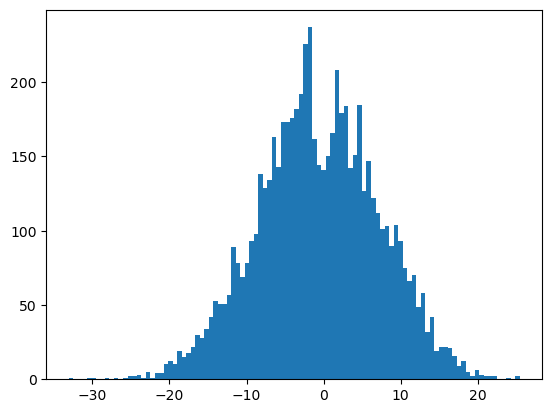

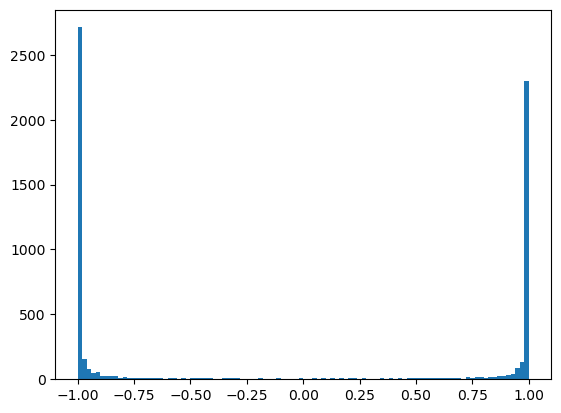

Training loss   = 1.9953980445861816
Validation loss = 2.069047212600708
Testing loss    = 2.094571352005005


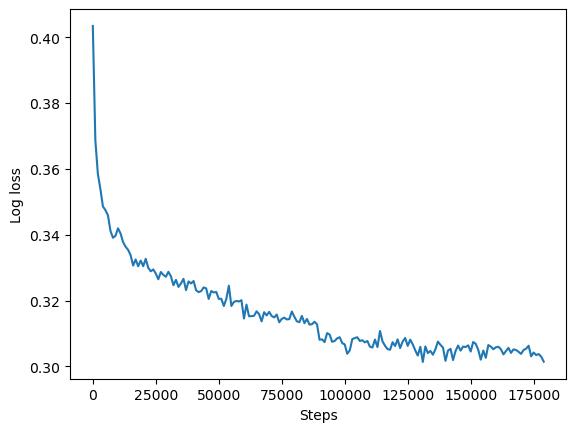

In [36]:
reset_train_eval()

In [38]:
# Predict

def predict(seed=None):
  if seed != None:
    gen = t.Generator().manual_seed(seed)

  generated_names = []
  for i in range(30):
    context = [0] * input_block_size

    result = ''
    while True:
      # Get logits
      emb = lookup[t.tensor([context])]
      hidden = t.tanh(emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ weights_hidden + biases_hidden)
      ####
      hidden = batchnorm_weights * (hidden - batchnorm_running_mean) / batchnorm_running_std + batchnorm_biases
      ####
      mlp_logits = hidden @ weights_final + biases_final

      # Exponentiate the logits and normalize them (sum to 1)
      probs = F.softmax(mlp_logits, dim=1)

      # Sample from probs to get the next character the neural network predicted
      sample_ind = t.multinomial(probs, num_samples=1, generator=gen).item()

      # End loop when the next sampled character is '#'
      if sample_ind == 0:
          break

      # Shift the context 'sliding window'
      context = context[1:] + [sample_ind]

      # Append result
      result += mapinttostr[sample_ind]

    generated_names += [result]

  print(generated_names)

In [39]:
predict(69)

['jacy', 'elis', 'jayten', 'bisayana', 'ayaunu', 'kirki', 'alyah', 'giannay', 'josion', 'imiangelynn', 'hadamyurie', 'mieqay', 'julielle', 'latie', 'kelai', 'roluwa', 'yaniah', 'silynn', 'dynon', 'elle', 'aleshera', 'aidin', 'beckalon', 'yannan', 'sam', 'adamiran', 'emnarthy', 'saber', 'jazarina', 'bennan']


## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693
val   2.106989622116089

### add batch norm layer
train 2.0668270587921143
val 2.104844808578491


In [ ]:
# SUMMARY + PYTORCHIFYING -----------

In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

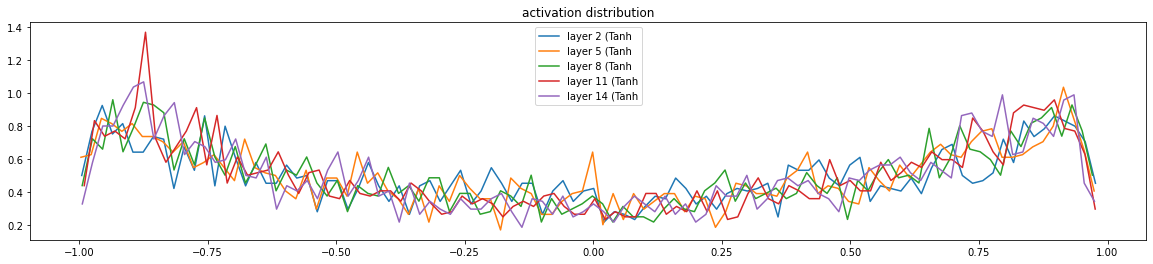

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean +0.000000, std 2.245584e-03
layer 8 (      Tanh): mean -0.000000, std 2.045742e-03
layer 11 (      Tanh): mean +0.000000, std 1.983134e-03
layer 14 (      Tanh): mean -0.000000, std 1.952382e-03


Text(0.5, 1.0, 'gradient distribution')

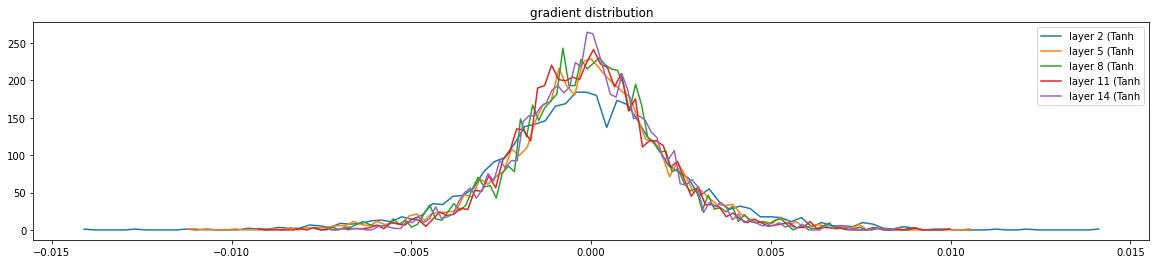

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.020534e-03 | grad:data ratio 8.012630e-03
weight  (30, 100) | mean +0.000246 | std 9.241077e-03 | grad:data ratio 4.881091e-02
weight (100, 100) | mean +0.000113 | std 7.132879e-03 | grad:data ratio 6.964619e-02
weight (100, 100) | mean -0.000086 | std 6.234305e-03 | grad:data ratio 6.073741e-02
weight (100, 100) | mean +0.000052 | std 5.742187e-03 | grad:data ratio 5.631483e-02
weight (100, 100) | mean +0.000032 | std 5.672205e-03 | grad:data ratio 5.570125e-02
weight  (100, 27) | mean -0.000082 | std 1.209416e-02 | grad:data ratio 1.160106e-01


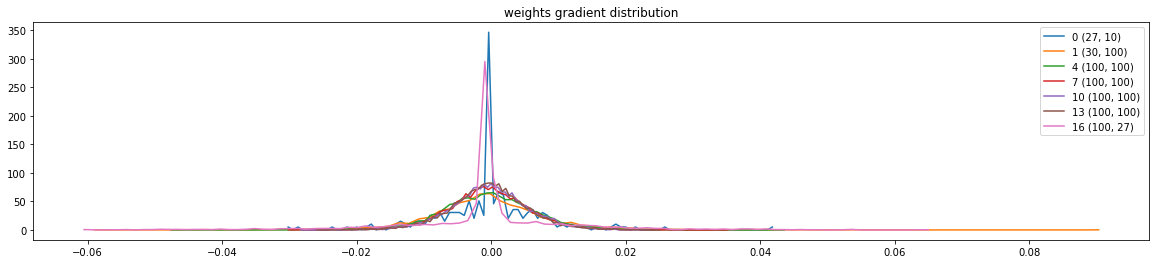

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

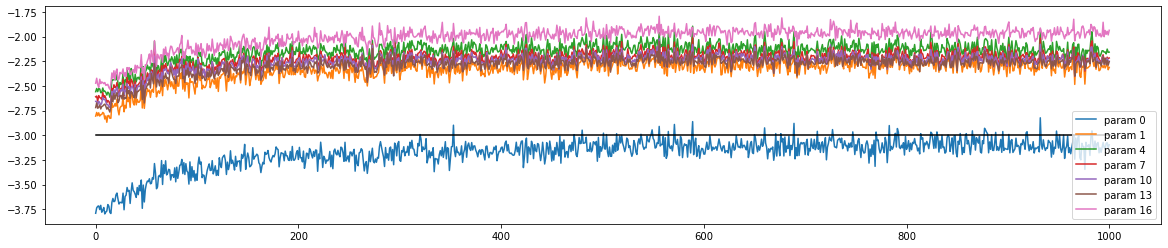

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.4002976417541504
val 2.3982467651367188


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carpah.
qarlileif.
jmrix.
thty.
sacansa.
jazhnte.
dpn.
arciigqeiunellaia.
chriiv.
kalein.
dhlm.
join.
qhinn.
sroin.
arian.
quiqaelogiearyxix.
kaeklinsan.
ed.
ecoia.
gtleley.


In [ ]:
# DONE; BONUS content below, not covered in video

In [ ]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [ ]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [ ]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953052997589111
